In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [2]:
covariates = ['Shops', 'ATMs', 'Downtown', 'Workday', 'Center', 'High']
df = pd.read_csv('ATM_sample.csv')
filtered_df = df.dropna(subset = covariates + ['Withdraw'])

#separating response and predictors
y = filtered_df['Withdraw']
X = filtered_df[covariates]
X = X.astype(float)
X_orig = X.copy()

#include distinct interactions and higher order terms
for i in range(len(covariates)):
    for j in range(i + 1, len(covariates)):
        #creating two-way interactions
        interaction_term_name = f'{covariates[i]}_{covariates[j]}'
        X[interaction_term_name] = X[covariates[i]] * X[covariates[j]]
        for k in range(j + 1, len(covariates)):
            #creating three-way interactions
            interaction_term_name_3way = f'{covariates[i]}_{covariates[j]}_{covariates[k]}'
            X[interaction_term_name_3way] = X[covariates[i]] * X[covariates[j]] * X[covariates[k]]

X['Shops_squared'] = X['Shops']**2
X['Shops_cubed'] = X['Shops']**3
X['ATMs_squared'] = X['ATMs']**2
X['ATMs_cubed'] = X['ATMs']**3

X['Shops_squared_Downtown'] = X['Shops_squared'] * X['Downtown']
X['Shops_squared_Workday'] = X['Shops_squared'] * X['Workday']
X['Shops_squared_Center'] = X['Shops_squared'] * X['Center']
X['Shops_squared_High'] = X['Shops_squared'] * X['High']

X['Shops_cubed_Downtown'] = X['Shops_cubed'] * X['Downtown']
X['Shops_cubed_Workday'] = X['Shops_cubed'] * X['Workday']
X['Shops_cubed_Center'] = X['Shops_cubed'] * X['Center']
X['Shops_cubed_High'] = X['Shops_cubed'] * X['High']

X['ATMs_squared_Downtown'] = X['ATMs_squared'] * X['Downtown']
X['ATMs_squared_Workday'] = X['ATMs_squared'] * X['Workday']
X['ATMs_squared_Center'] = X['ATMs_squared'] * X['Center']
df['ATMs_squared_High'] = X['ATMs_squared'] * X['High']

X['ATMs_cubed_Downtown'] = X['ATMs_cubed'] * X['Downtown']
X['ATMs_cubed_Workday'] = X['ATMs_cubed'] * X['Workday']
X['ATMs_cubed_Center'] = X['ATMs_cubed'] * X['Center']
X['ATMs_cubed_High'] = X['ATMs_cubed'] * X['High']


In [3]:
#enriched model with added predictors
l1_vals = [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split data into train and test then use cv to find optimal params
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 42) 
enet_1 = ElasticNetCV(l1_ratio = l1_vals, cv = 5, random_state=42, max_iter = 5000)
enet_1.fit(X_train, y_train)

#optimal parameters
best_alpha1 = enet_1.alpha_
best_l1_1 = enet_1.l1_ratio_

#find test mse
y_pred1 = enet_1.predict(X_test)
test_mse1 = mean_squared_error(y_pred1,y_test)

#find cv mse 
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_mse1 = cross_val_score(enet_1, X_test, y_test, cv = kf, scoring = 'neg_mean_squared_error')

print(f'CV mse: {-np.mean(cv_mse1)}')
print(f'test split mse: {test_mse1}')
print(f'Best trade-off value: {best_l1_1}')
print(f'Best penalty value: {best_alpha1}\n')

#base model for comparison same form as above
l1_vals = [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
scaler = StandardScaler()
X_orig_scaled = scaler.fit_transform(X_orig)

X_og_train, X_og_test, y_og_train, y_og_test = train_test_split(X_orig_scaled, y, test_size=0.2, random_state = 42)
enet_2 = ElasticNetCV(l1_ratio = l1_vals, cv = 5, random_state = 42, max_iter = 5000)
enet_2.fit(X_orig_scaled, y)

best_alpha2 = enet_2.alpha_
best_l1_2 = enet_2.l1_ratio_

y_pred2 = enet_2.predict(X_og_test)
test_mse2 = mean_squared_error(y_pred2,y_og_test)

enet_og = ElasticNet(alpha = best_alpha2, l1_ratio = best_l1_2, random_state = 42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse2 = cross_val_score(enet_og, X_og_test, y_og_test, cv = kf, scoring = 'neg_mean_squared_error')

print(f'CV mse for base model: {-np.mean(cv_mse2)}')
print(f'test mse for base model: {test_mse2}')
print(f'Best trade-off value for base model: {best_l1_2}')
print(f'Best penalty for base model: {best_alpha2}')

CV mse: 0.2808545804586749
test split mse: 0.2786949162685838
Best trade-off value: 1.0
Best penalty value: 0.02488713841953707

CV mse for base model: 6.694199774366149
test mse for base model: 6.6931421714858965
Best trade-off value for base model: 1.0
Best penalty for base model: 0.0247427207145814


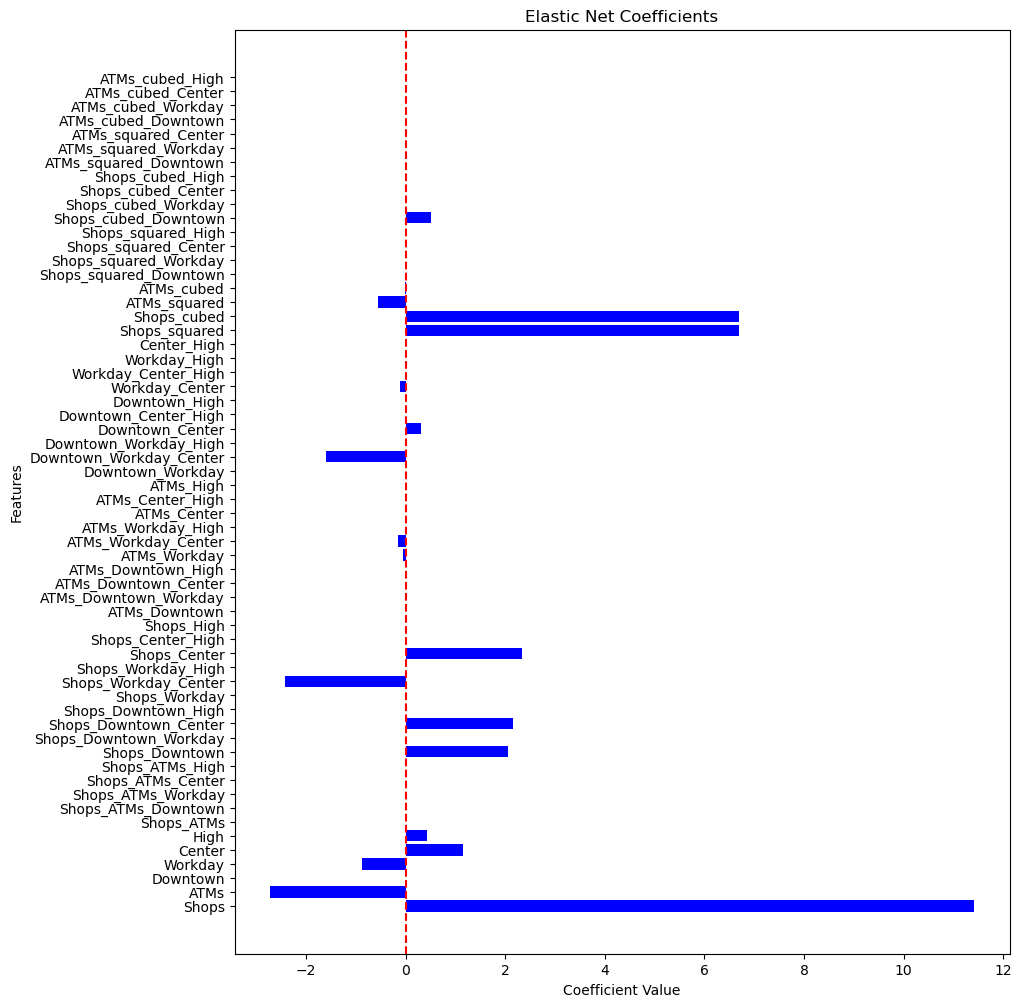

In [13]:
enet_1_coefficients = enet_1.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': enet_1_coefficients})

#plot coefficient values for enriched model
plt.figure(figsize=(10,12))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Elastic Net Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

In [ ]:
enet_2_coefficients = enet_2.coef_
features_base = X_orig.columns

coef_df = pd.DataFrame({'Feature': features_base, 'Coefficient': enet_2_coefficients})

#plot coefficients for base model
plt.figure(figsize=(8, 4))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.axvline(0, color='red', linestyle='--') 
plt.title('Elastic Net Coefficients Base')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()